In [1]:
from pyspark.sql.functions import *

In [69]:
df = spark.read.load('data/complete.csv',
                     format="csv", inferSchema="true", header="true")

In [3]:
df.schema

StructType(List(StructField(category,StringType,true),StructField(date,TimestampType,true),StructField(Wt Range,StringType,true),StructField(Avg Wt,IntegerType,true),StructField(Price Range,StringType,true),StructField(Avg Price,DoubleType,true),StructField(Extra,StringType,true)))

In [70]:
df.take(5)

[Row(category='Slaughter Cows Boner 80-85%', date=datetime.datetime(2019, 5, 2, 0, 0), Wt Range='1050-1150', Avg Wt=1100, Price Range='52.00-54.00', Avg Price=52.52, Extra=None),
 Row(category='Slaughter Cows Boner 80-85%', date=datetime.datetime(2019, 5, 2, 0, 0), Wt Range='990', Avg Wt=990, Price Range='46.00', Avg Price=46.0, Extra='Low Dressing'),
 Row(category='Slaughter Cows Boner 80-85%', date=datetime.datetime(2019, 5, 2, 0, 0), Wt Range='1200-1330', Avg Wt=1265, Price Range='51.00-52.00', Avg Price=51.53, Extra=None),
 Row(category='Slaughter Cows Boner 80-85%', date=datetime.datetime(2019, 5, 2, 0, 0), Wt Range='1330', Avg Wt=1330, Price Range='48.00', Avg Price=48.0, Extra='Low Dressing'),
 Row(category='Slaughter Cows Lean 85-90%', date=datetime.datetime(2019, 5, 2, 0, 0), Wt Range='900-1120', Avg Wt=1046, Price Range='46.00-50.00', Avg Price=48.39, Extra=None)]

In [79]:
# I want to convert the wt range to a high wt and low wt, and the price range to a high price and low price
withPriceCols = df.withColumn("priceRange", split(col("Price Range"), '-').cast("array<int>")) \
                    .withColumn("lowPrice", array_min(col("priceRange"))) \
                    .withColumn("highPrice", array_max(col("priceRange"))) \
                    .drop("Price Range") \
                    .drop("priceRange")

auctionResults = withPriceCols.withColumn("weightRange", split(col("Wt Range"), '-').cast("array<int>")) \
                                .withColumn("lowWeight", array_min(col("weightRange"))) \
                                .withColumn("highWeight", array_max(col("weightRange"))) \
                                .drop("Wt Range") \
                                .drop("weightRange")

In [80]:
auctionResults.show(10)

+--------------------+-------------------+------+---------+------------+--------+---------+---------+----------+
|            category|               date|Avg Wt|Avg Price|       Extra|lowPrice|highPrice|lowWeight|highWeight|
+--------------------+-------------------+------+---------+------------+--------+---------+---------+----------+
|Slaughter Cows Bo...|2019-05-02 00:00:00|  1100|    52.52|        null|      52|       54|     1050|      1150|
|Slaughter Cows Bo...|2019-05-02 00:00:00|   990|     46.0|Low Dressing|      46|       46|      990|       990|
|Slaughter Cows Bo...|2019-05-02 00:00:00|  1265|    51.53|        null|      51|       52|     1200|      1330|
|Slaughter Cows Bo...|2019-05-02 00:00:00|  1330|     48.0|Low Dressing|      48|       48|     1330|      1330|
|Slaughter Cows Le...|2019-05-02 00:00:00|  1046|    48.39|        null|      46|       50|      900|      1120|
|Slaughter Cows Le...|2019-05-02 00:00:00|  1017|    40.03|Low Dressing|      39|       42|     

In [8]:
auctionResults.schema

StructType(List(StructField(category,StringType,true),StructField(date,TimestampType,true),StructField(Avg Wt,IntegerType,true),StructField(Avg Price,DoubleType,true),StructField(Extra,StringType,true),StructField(lowPrice,IntegerType,true),StructField(highPrice,IntegerType,true),StructField(lowWeight,IntegerType,true),StructField(highWeight,IntegerType,true)))

In [74]:
auctionResults.select("category").distinct().show(20, False)

+--------------------------------------------+
|category                                    |
+--------------------------------------------+
|Cow-Calf Pairs Medium and Large 1-2         |
|Feeder Steers Medium and Large 2            |
|Slaughter Bulls Y.G. 1                      |
|Slaughter Cows Boner 80-85%                 |
|Bred Cows Medium and Large 1-2 Per Head     |
|Feeder Bulls Medium and Large 1             |
|Cow-Calf Pairs Small 1-2                    |
|Cow-Calf Pairs Medium and Large 2-3         |
|Bred Cows Medium and Large 2-3 per head     |
|Feeder Heifers Medium and Large 2           |
|Bred Cows Medium and Large 1-2 per head     |
|Cow-Calf Pairs Small 2-3                    |
|Feeder Heifers Medium and Large 2-3         |
|Feeder Steers and Bulls Medium and Large 2-3|
|Slaughter Cows Lean 85-90%                  |
|Feeder Bulls Medium and Large 3             |
|Feeder Heifers Medium and Large 1           |
|Feeder Heifers Medium and Large 3           |
|Slaughter Co

In [95]:
filteredResults = auctionResults.where(
    col("category").startswith("Feeder Bulls Medium and Large"))  \
    .where(col("lowWeight") <= 475) \
    .where(col("highWeight") >= 475)

In [96]:
filteredResults.take(5)

[Row(category='Feeder Bulls Medium and Large 1', date=datetime.datetime(2019, 5, 2, 0, 0), Avg Wt=465, Avg Price=155.66, Extra=None, lowPrice=152, highPrice=160, lowWeight=455, highWeight=480),
 Row(category='Feeder Bulls Medium and Large 3', date=datetime.datetime(2019, 5, 2, 0, 0), Avg Wt=466, Avg Price=133.12, Extra=None, lowPrice=128, highPrice=138, lowWeight=455, highWeight=490),
 Row(category='Feeder Bulls Medium and Large 1', date=datetime.datetime(2019, 3, 27, 0, 0), Avg Wt=465, Avg Price=154.46, Extra=None, lowPrice=152, highPrice=158, lowWeight=455, highWeight=480),
 Row(category='Feeder Bulls Medium and Large 3', date=datetime.datetime(2019, 3, 27, 0, 0), Avg Wt=466, Avg Price=132.85, Extra=None, lowPrice=129, highPrice=137, lowWeight=455, highWeight=490),
 Row(category='Feeder Bulls Medium and Large 1', date=datetime.datetime(2019, 1, 16, 0, 0), Avg Wt=461, Avg Price=146.01, Extra=None, lowPrice=142, highPrice=150, lowWeight=455, highWeight=480)]

In [15]:
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [97]:
date_list = [x[1] for x in filteredResults.toLocalIterator()]
avg_price_list = [x[3] for x in filteredResults.toLocalIterator()]

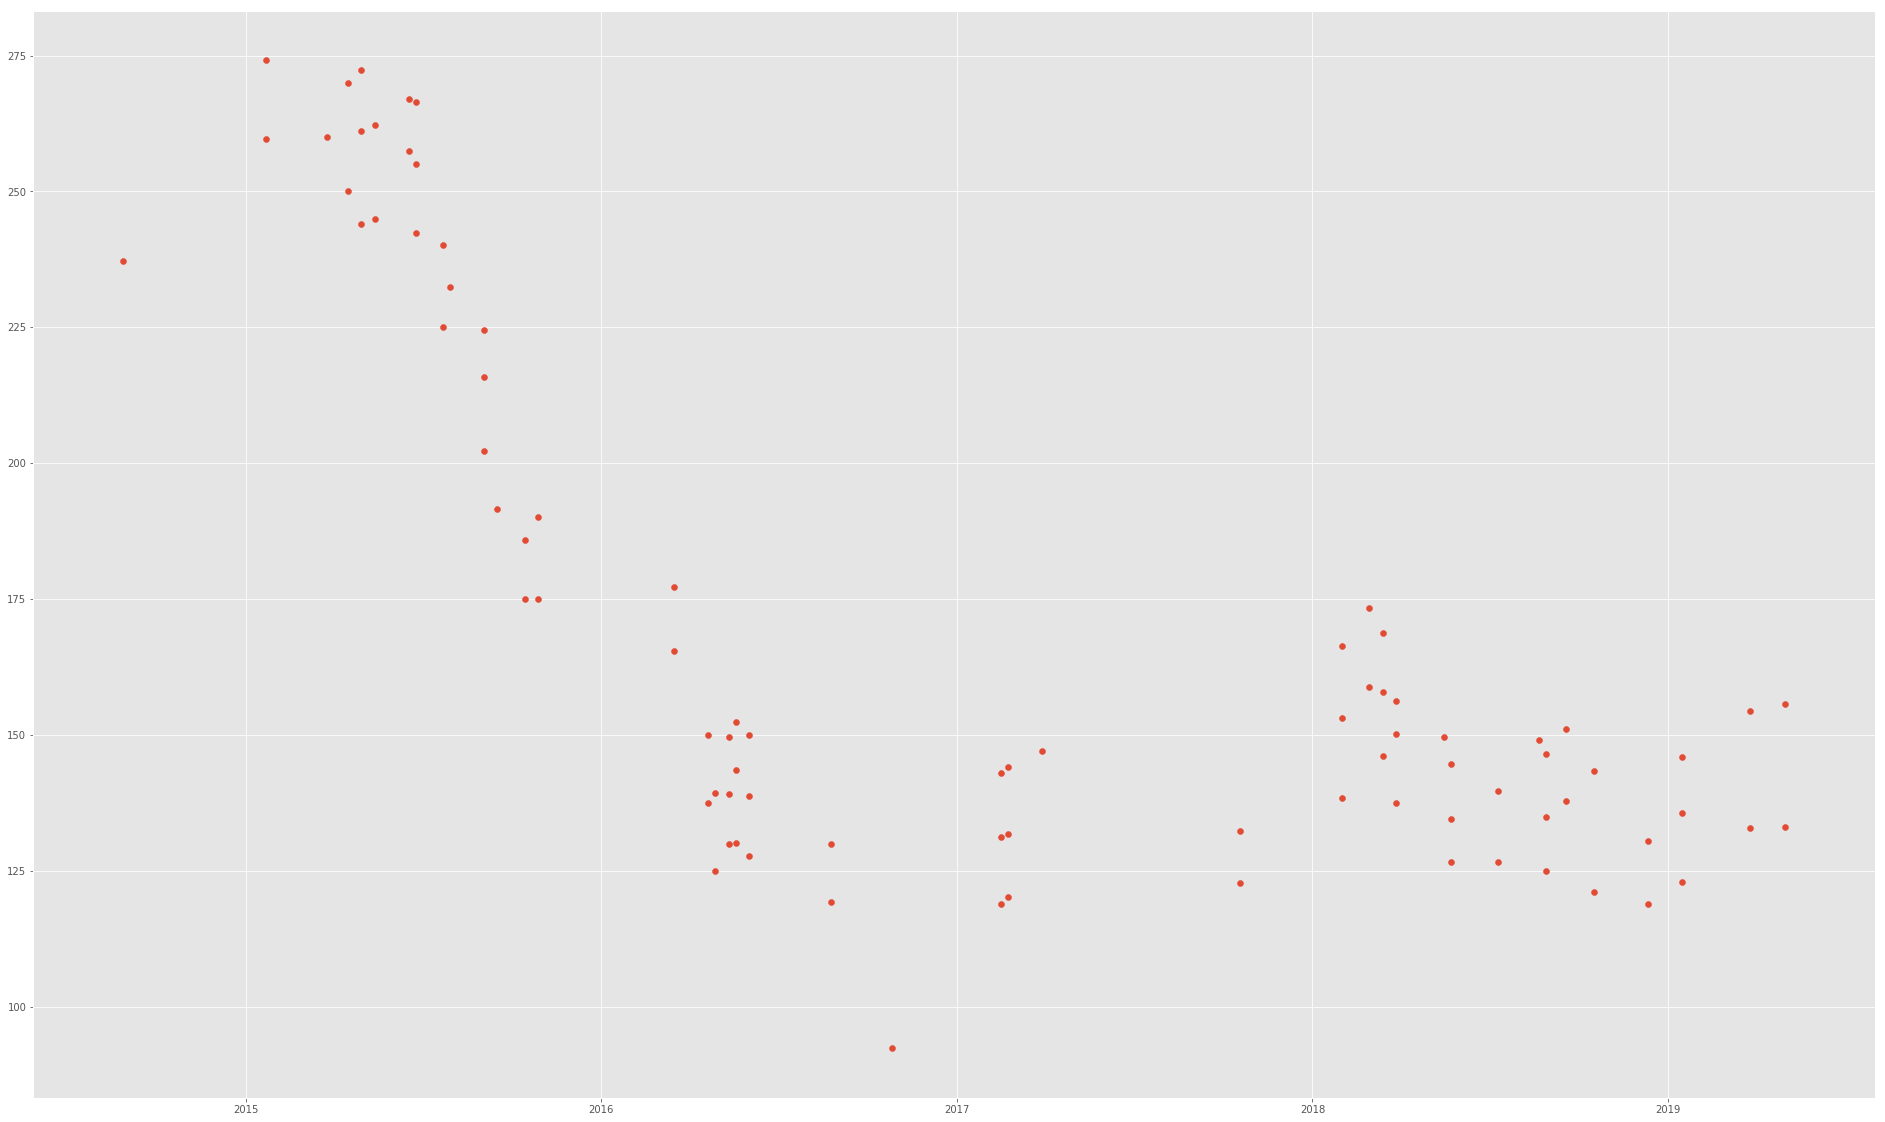

In [98]:
plt.figure(figsize=(33,20))
plt.scatter(date_list, avg_price_list)

plt.autoscale()
plt.show()

In [66]:
filteredResults.select("date", "avg price").show(10)

+-------------------+---------+
|               date|avg price|
+-------------------+---------+
|2019-04-25 00:00:00|   140.04|
|2019-04-25 00:00:00|   127.54|
|2019-03-20 00:00:00|   140.04|
|2019-03-20 00:00:00|   127.54|
|2019-03-13 00:00:00|   140.04|
|2019-03-13 00:00:00|   127.54|
|2019-02-27 00:00:00|   140.04|
|2019-02-27 00:00:00|   127.54|
|2019-02-20 00:00:00|   140.04|
|2019-02-20 00:00:00|   127.54|
+-------------------+---------+
only showing top 10 rows



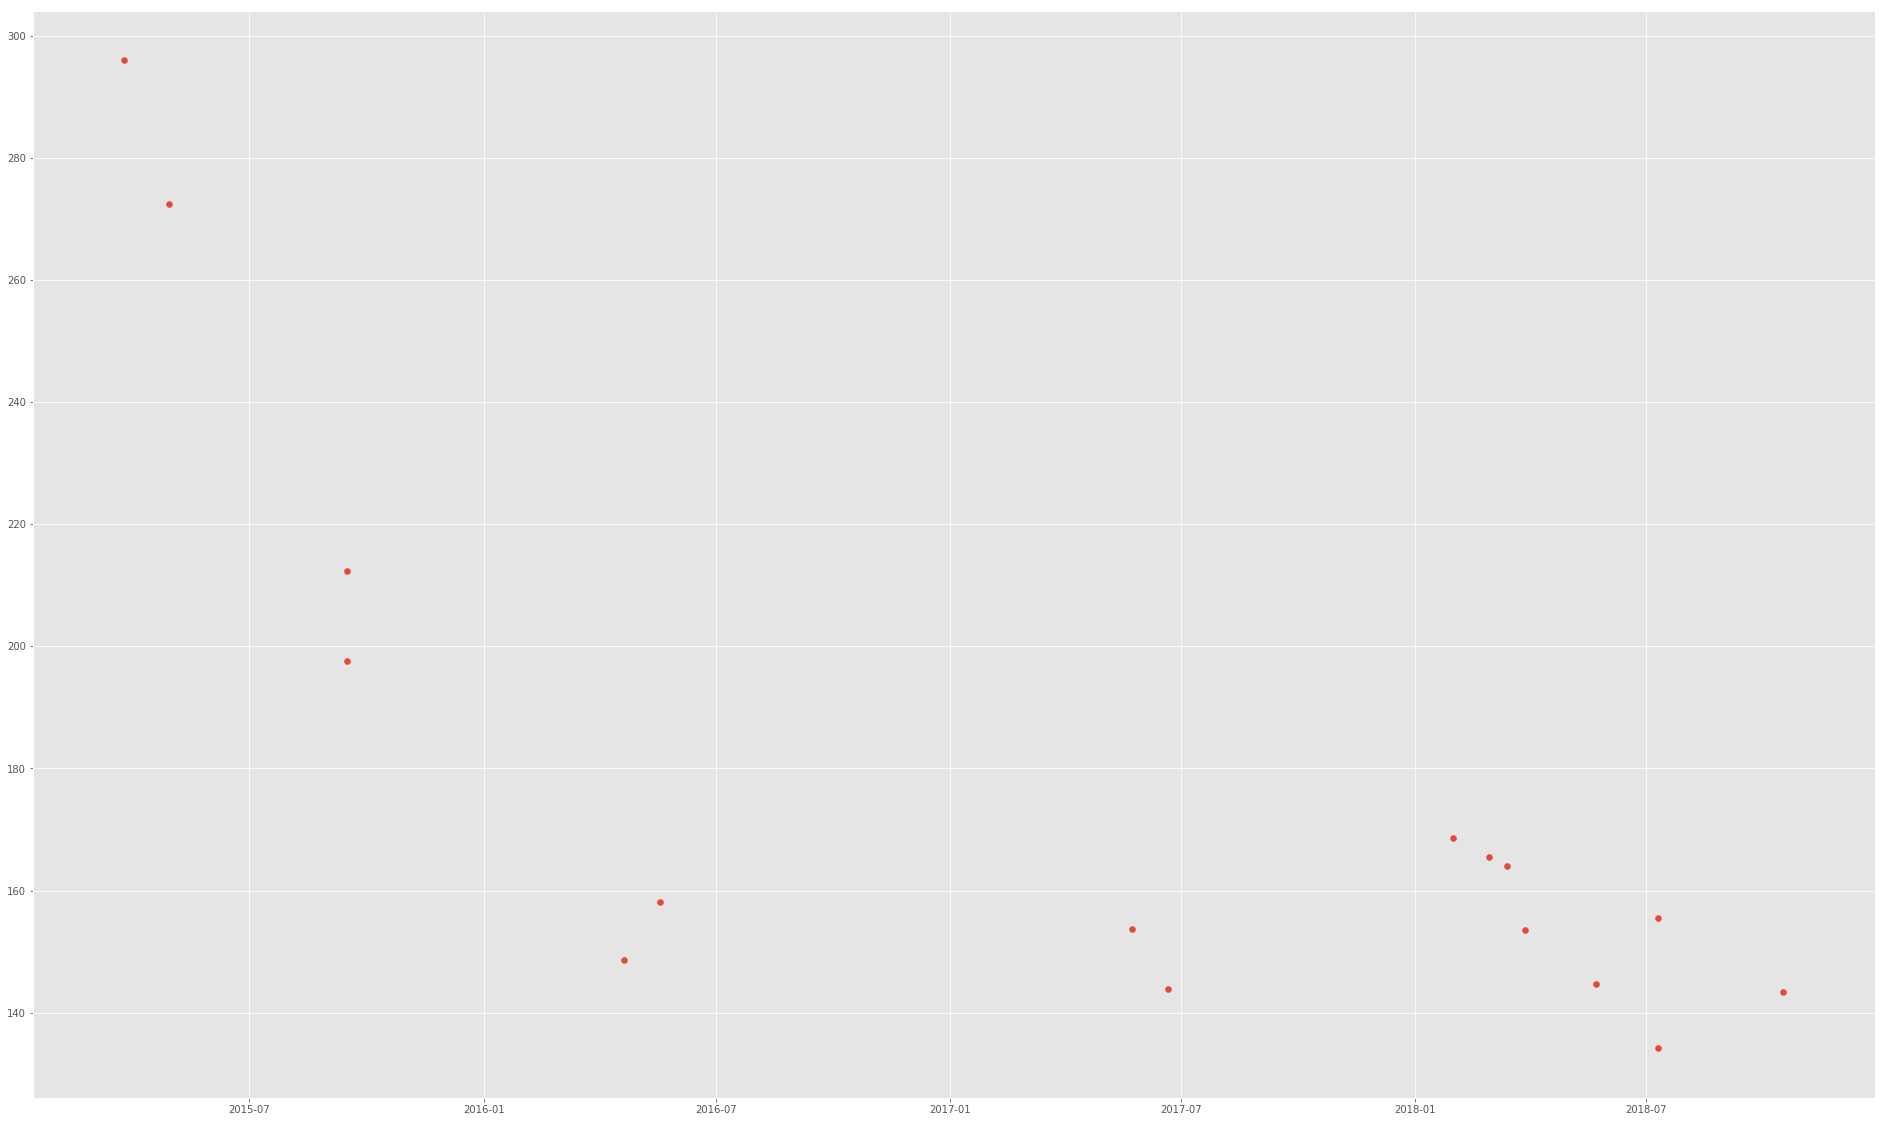

In [94]:
plt.figure(figsize=(33,20))
plt.scatter(date_list, avg_price_list)

plt.autoscale()
plt.show()